For this task, I will use the CIFAR-10 dataset, which consists of 10 classes of coloured images, including airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck. The dataset contains 60,000 images - 50,000 images for the training set and 10,000 images for the testing set. Each image is a 32x32 pixel RGB image (3 channels: red, green, and blue), labeled according to its class. The pixel values range from 0 to 255, representing the intensity of each color channel.

I had issues importing cifar-10 from conventional sources such as keras or PyTorch, so I used Kaggle instead and downloaded the dataset as compressed numpy arrays: https://www.kaggle.com/datasets/guesejustin/cifar10-keras-files-cifar10load-data?resource=download

Below I will load the datasetand display some of its characteristics mentioned above:

Training set shape: (50000, 32, 32, 3) images
Test set shape: (10000, 32, 32, 3) images
Image dimensions: 32x32 pixels


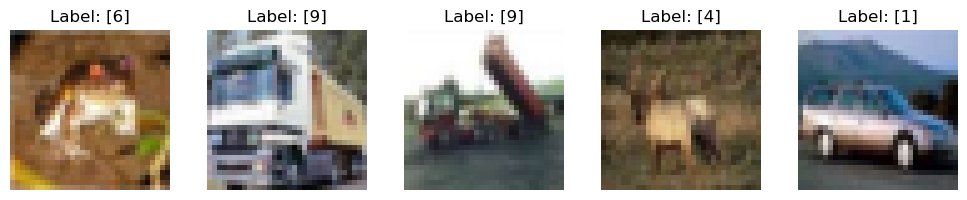

In [54]:
import numpy as np
import matplotlib.pyplot as plt

cifar_data = np.load('./cifar-10.npz')

filenames = ["x_train","y_train","x_test","y_test"]
nps = []

for filename in filenames:
    nps.append(cifar_data[filename])

x_train, y_train, x_test, y_test = nps

print(f"Training set shape: {x_train.shape} images")
print(f"Test set shape: {x_test.shape} images")
print(f"Image dimensions: {x_train.shape[1]}x{x_train.shape[2]} pixels")

# I will also display some sample images from the dataset to visualise the images I am working with

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(x_train[i], cmap='gray')
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

I will create a base convolutional neural network (using PyTorch) to classify images.
Firstly I need to normalise the images, I will use the "mean" and "std" values calulated to CIFAR-10 to normalize each RGB channel seperately:

In [55]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, RandomHorizontalFlip, RandomCrop
from torch.utils.data import DataLoader, TensorDataset

mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

train_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

test_transform = Compose([
    ToTensor(),
    Normalize(mean, std)
])

Next I need to convert both the training and testing set to PyTorch tensors, as well as the labels, as this is what the model expects. I also apply the transformations above to x_train and y_train:

In [56]:
from PIL import Image

x_train_transformed = torch.stack([
    train_transform(Image.fromarray(img)) for img in x_train
])
x_test_transformed = torch.stack([
    test_transform(Image.fromarray(img)) for img in x_test
])

y_train_tensor = torch.tensor(y_train).long()
y_test_tensor = torch.tensor(y_test).long()

Now the input is prepared, I will start building the model.
I will first need to establish a baseline CNN model, which I will build on and add improvements, and then carry out hyperparameter tuning:

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 2 Convolutional Layers
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        
        # 1 Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 2 Fully Connected Layers
        self.fc1 = nn.Linear(16 * 14 * 14, 256)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
model = CNN()

# Baseline Hyperparameters

batch_size = 64
learning_rate = 0.01
num_epochs = 6

To start with, I have defined a simple base convolutional network with 2 convolutional layers and 2 fully connected layers, and 1 pooling layer. The role of the pooling layer is to reduce the spatial dimensions of feature maps while retaining most of the important information.

In the forward pass function, the first and second convolutional layer is applied with a ReLU activation function. Then pooling is applied, and the feature maps are flattened into 1D to be fed into the fully connected layers. Then the first fully connected layer is applied with ReLU, and the second with no activation as it is handled in the loss function.

Under this, I have specified the hyperparameters that I will start off with:
- Batch size: 64 - (higher = more stable gradient updates but slower weight updates, lower = faster weight updates but gradients are noiser)
- Learning rate: 0.01 - (higher = faster training but risk of overshooting the minimum, lower = slower training but ensures more stable and precise convergence at minimum)
- Epochs: 6 - (higher = risk of overfitting, lower = risk of underfitting)

I also need to define the loss function and the optimizer for the baseline model. I will use cross-entropy loss as it is standard for multi-class classification problems, and also the adam optimizer:

In [58]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Before training I will also need to wrap the data in loaders now that batch size is defined:

In [59]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(x_train_transformed, y_train_tensor)
test_dataset = TensorDataset(x_test_transformed, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

I will use various metrics to measure the performance of the models:
- Loss - quantifies the model "error"
- Accuracy - proportion of correct predictions out of all
- Precision - measures the accuracy of positive predictions
- Recall - measures ability of the model to identify all positive cases
- F1 Score - combination of Precision and Recall, which is the harmonic mean of both

Now I will train the model for the specified baseline number of epochs.

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    all_labels = []
    all_predictions = [] 

    for images, labels in train_loader:
        labels = labels.squeeze(1)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
    
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Epoch [1/6], Loss: 1.7243, Accuracy: 36.52%
Precision: 0.3600, Recall: 0.3652, F1 Score: 0.3588
Epoch [2/6], Loss: 1.5018, Accuracy: 45.56%
Precision: 0.4508, Recall: 0.4556, F1 Score: 0.4516
Epoch [3/6], Loss: 1.3872, Accuracy: 50.22%
Precision: 0.4996, Recall: 0.5022, F1 Score: 0.5000
Epoch [4/6], Loss: 1.3208, Accuracy: 52.82%
Precision: 0.5253, Recall: 0.5282, F1 Score: 0.5258
Epoch [5/6], Loss: 1.2647, Accuracy: 54.93%
Precision: 0.5474, Recall: 0.5493, F1 Score: 0.5475
Epoch [6/6], Loss: 1.2224, Accuracy: 56.45%
Precision: 0.5632, Recall: 0.5645, F1 Score: 0.5631


As seen above, the model converges to 56.45% accuracy from the baseline model with a loss of 1.22. Precision and Recall are also low with 0.563 and 0.564, which leads to a low F1 score aswell.

This isn't a strong result but creates a great starting point to build on.
I first want to experiment with adding 1 more convolutional layer and 1 more fully connected layer. The convolutional layer will improve feature extraction and the fully connected layer will allow the model to learn more complex patterns: